In [22]:
import os
os.chdir('/home/dgotzens/scripts/')

import matplotlib.pyplot as plt
import tools, torch, pickle

nfft = 2_048
maxdist = 50
lightspeed = 299_792_458 
f_start, f_end = 76009996288.0, 80289505280.0
t_chirp = 0.00006489000224974006
hertz_per_meter = (f_end-f_start) / t_chirp / lightspeed

folder = '/home/dgotzens/recording/'

loading /home/dgotzens/recording/exports/a02_data.pt...


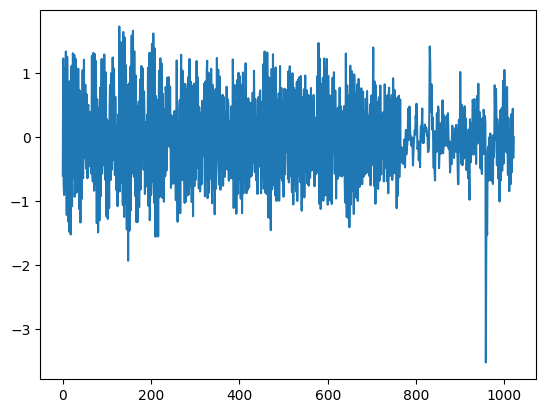

: 

In [31]:
import numpy, torch, pickle
from matplotlib.ticker import EngFormatter
from matplotlib import pyplot as plt
# load measurement
folder = '/home/dgotzens/recording/exports/'
orientation = 'a'
dist = 2
nfft = 2048
ranges = numpy.arange(nfft)*50/nfft

print(f'loading {folder}{orientation}{dist:02d}_data.pt...')
# print(f'loading {folder}test_data.pt...')

data = torch.load(f'{folder}{orientation}{dist:02d}_data.pt')
# data = torch.load(f'{folder}test_data.pt')
M,K,L = data.shape
with open(f'{folder}{orientation}{dist:02d}_timestamps.pkl', 'rb') as f:
# with open(f'{folder}test_timestamps.pkl', 'rb') as f:
    timestamps = pickle.load(f)
with open(f'{folder}{orientation}{dist:02d}_angle.pkl', 'rb') as f:
# with open(f'{folder}test_angle.pkl', 'rb') as f:
    angle = pickle.load(f)
if numpy.isnan(angle[0]):
    angle[0] = angle[1]
plt.plot(data[:,20,2000].real)
# plt.ylim(-1,1)
plt.show()

In [ ]:
window = torch.hann_window(M).unsqueeze(-1)
data_abs_mean = torch.zeros(nfft,L)
for k in range(K):
    fft = torch.fft.fft(window*data[:,k,:], n=nfft, dim=0)
    data_abs_mean += fft.abs()/K
# plot data
plt.pcolormesh(180/3.14159265*numpy.asarray(angle)-90, ranges, 20*data_abs_mean.log10().numpy(), vmin=-40, vmax=40)
plt.title(f'orientation {orientation.upper()}, refl @{dist}.0m, tx={tx}',)
plt.gca().xaxis.set_major_formatter(EngFormatter('°'))
plt.gca().yaxis.set_major_formatter(EngFormatter('m'))
plt.xlabel('Angle')
plt.ylabel('Range')
plt.grid()
plt.show()


In [2]:
data = torch.load(folder + 'a00_data.pt')
M,K,L = data.shape

with open(folder +'a00_angle.pkl', 'rb') as f:
    angle, angle_ts = pickle.load(f)

with open(folder +'a00_timestamps.pkl', 'rb') as f:
    timestamps = pickle.load(f)


In [3]:
lirp_angle = []
n = 0
for ts in timestamps:
    while n+1 < len(angle_ts)-1 and angle_ts[n+1] < ts:
        n += 1
    a0 = angle[n]
    a1 = angle[n+1]
    t0 = angle_ts[n]
    t1 = angle_ts[n+1]
    t = (ts-t0)/(t1-t0)
    lirp_angle.append(180/3.141592653589*(a0*(1-t) + a1*t))

if angle[0]>angle[-1]:
    lirp_angle = [180.0 - l/L*180 for l in range(L)]
else:
    lirp_angle = [l/L*180 for l in range(L)]


torch.Size([2048, 192])


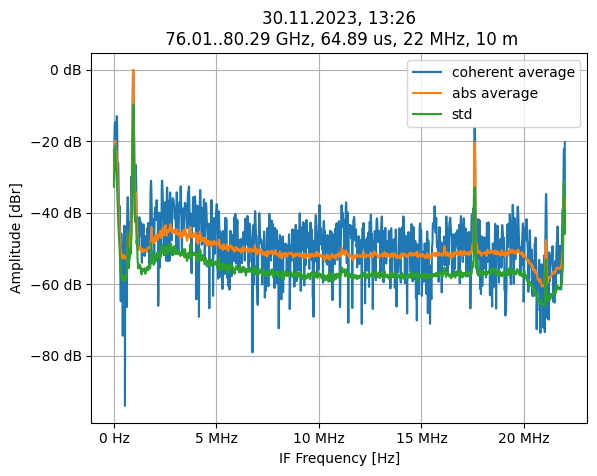

In [23]:
from matplotlib.ticker import EngFormatter

maxdist = 50
window = torch.hann_window(M)
window = window / torch.sum(window) / 2**15
data_fft = torch.fft.fft(data[:,:,2250] * window[:,None], n=nfft, axis=0)
data_fft = torch.fft.fft(data[:,:,2250] * window[:,None], n=nfft, axis=0)
print(data_fft.shape)
data_mean_coh = torch.abs(torch.mean(data_fft, axis=1))
data_mean_abs = torch.mean(torch.abs(data_fft), axis=1)
data_std = torch.std(torch.abs(data_fft), axis=1)
data_mean_coh /= torch.max(data_mean_coh)
data_std /= torch.max(data_mean_abs)
data_mean_abs /= torch.max(data_mean_abs)
distance = torch.linspace(0, maxdist,nfft)
frequency = 2 * distance * hertz_per_meter

name = '30.11.2023, 13:26'
settings = f" {f_start/1e9:.2f}..{f_end/1e9:.2f} GHz, {t_chirp*1e6:.2f} us, {22} MHz, {10} m"

plt.plot(frequency, 20*torch.log10(data_mean_coh), label='coherent average')
plt.plot(frequency, 20*torch.log10(data_mean_abs), label='abs average')
plt.plot(frequency, 20*torch.log10(data_std), label='std')
plt.legend()
plt.title(f'{name}\n{settings}')
plt.xlabel('IF Frequency [Hz]')
plt.ylabel('Amplitude [dBr]') 
plt.grid(True) 
plt.grid(True, which='minor') 
plt.gca().xaxis.set_major_formatter(EngFormatter(unit='Hz'))
plt.gca().yaxis.set_major_formatter(EngFormatter(unit='dB'))
# plt.xlim([0, 5e6])
# plt.ylim([-120, 10])

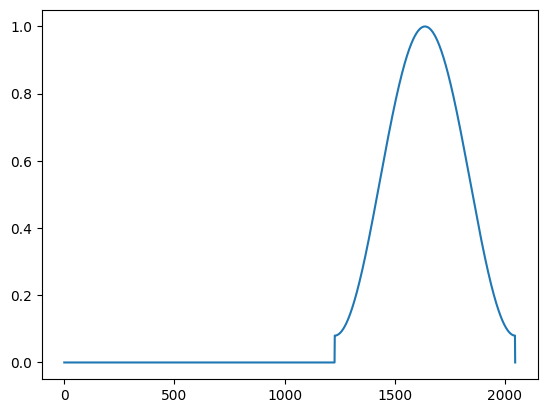

In [5]:
bp = torch.zeros(nfft)
bins_per_meter = nfft/maxdist
bp_start = int(30*bins_per_meter)
bp_len = int(20*bins_per_meter)
bp[bp_start:bp_start+bp_len] = torch.hamming_window(bp_len)
bp=bp.unsqueeze(-1)
plt.plot(bp)
plt.show()

done


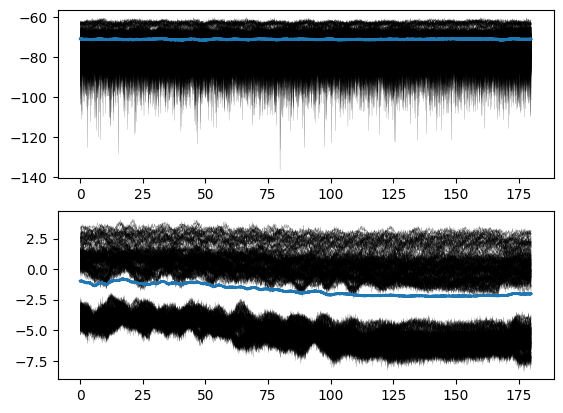

In [6]:
data_fft_bp_mean_coh = torch.empty((K,L))
data_fft_bp_mean_abs = torch.empty((K,L))

window = torch.hann_window(M).unsqueeze(-1)
f,ax=plt.subplots(2)
for k in range(K):
    print(k, end='\r')
    data_fft_bp_mean_coh[k,:] = (torch.fft.fft(window*data[:,k,:], n=nfft, dim=0)*bp).mean(0).abs()
    data_fft_bp_mean_abs[k,:] = (torch.fft.fft(window*data[:,k,:], n=nfft, dim=0)*bp).abs().mean(0)
    ax[0].plot(lirp_angle, 20*data_fft_bp_mean_coh[k,:].abs().log10(), color='k', linewidth=0.1)
    ax[1].plot(lirp_angle, 20*data_fft_bp_mean_abs[k,:].abs().log10(), color='k', linewidth=0.1)
print('done')
ax[0].plot(lirp_angle, 20*data_fft_bp_mean_coh.abs().mean(0).log10(), linewidth=2)
ax[1].plot(lirp_angle, 20*data_fft_bp_mean_abs.abs().mean(0).log10(), linewidth=2)

tensor(5.9557) tensor(31.5562)
tensor(5.9036) tensor(62.4351)
tensor(5.9032) tensor(53.4370)
tensor(6.0185) tensor(45.4219)


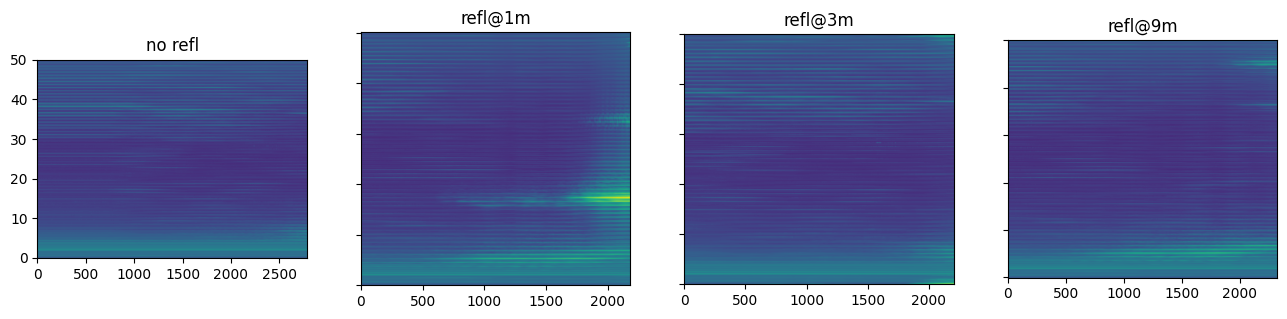

In [7]:
f, ax = plt.subplots(1,4,sharey=True)
nfft = 2048
f.set_size_inches((16,4))
window = torch.hamming_window(M)
for n, dist in enumerate((0,1,3,9)):
    data = torch.load(folder + f'd{dist:02d}_data.pt')
    M,K,L = data.shape
    data_fft = torch.fft.fft(window[:,None,None]*data, n=nfft, dim=0)
    ax[n].imshow(20*data_fft.abs().mean(1).log10(), vmin=0, vmax=60, origin='lower')
    print(20*data_fft.abs().mean(1).log10().min(), 20*data_fft.abs().mean(1).log10().max())
    ax[n].set_yticks(range(0,nfft+1,nfft//5), [round(m*maxdist/nfft) for m in range(0,nfft+1,nfft//5)])
    ax[n].set_title(f'refl@{dist}m' if dist>0 else 'no refl')


NameError: name 'M' is not defined

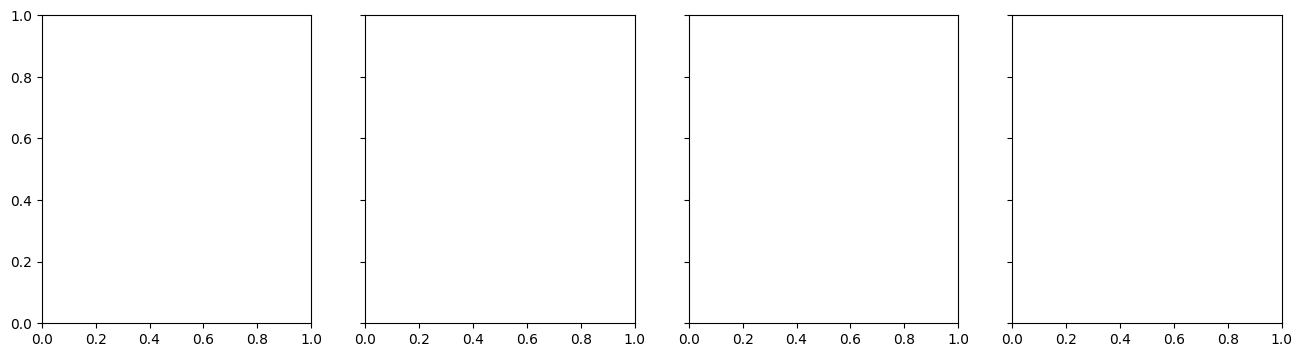

In [2]:
def runavg(x, length=10):
    result = torch.zeros_like(x)
    L = x.shape[-1]
    for n in range(length):
        result[...,n:] += x[...,n:]
    return result/length

f, ax = plt.subplots(1,4,sharey=True)
nfft = 2048
f.set_size_inches((16,4))
window = torch.hamming_window(M)
for n, dist in enumerate((0,1,3,9,27)):
    data = torch.load(folder + f'a{dist:02d}_data.pt')
    M,K,L = data.shape
    data_fft_smooth_dB = 20*runavg(torch.fft.fft(window[:,None,None]*data, n=nfft, dim=0)).abs().mean(1).log10()
    im= ax[n].imshow(data_fft_smooth_dB, vmin=0, vmax=60, origin='lower')
    ax[n].set_yticks(range(0,nfft+1,nfft//5), [round(m*maxdist/nfft) for m in range(0,nfft+1,nfft//5)])
    ax[n].set_title(f'refl@{dist}m' if dist>0 else 'no refl')
f.colorbar(im,ax=ax.ravel().tolist())

In [3]:
# load background
background = torch.load(folder + f'180_data.pt')
M,K,L = background.shape
print(background.shape)
with open(folder + '180_timestamps.pkl', 'rb') as handle:
    timestamps = pickle.load(handle)
with open(folder + '180_angle.pkl', 'rb') as handle:
    angle = pickle.load(handle)   


window = torch.hann_window(M)
# background_fft_runavg = runavg(torch.fft.fft(window[:,None,None]*background, n=1024, dim=0))
background_fft_runavg = torch.fft.fft(window[:,None,None]*background, n=1024*4, dim=0)[:500,:,:]
plt.imshow(20*background_fft_runavg.abs().mean(1).log10(), origin='lower')
plt.xticks(range(0,L,L//6), [round(180/3.14159265*angle[l]) for l in range(0,L,L//6)])
plt.colorbar(location='bottom')
plt.gcf().set_size_inches(5,10)
plt.show()

torch.Size([1022, 192, 5737])


: 

In [ ]:
# load 1m
a03 = torch.load(folder + f'a03_data.pt')
M,K,L = a03.shape
with open(folder + 'a03_timestamps.pkl', 'rb') as handle:
    timestamps = pickle.load(handle)
with open(folder + 'a03_angle.pkl', 'rb') as handle:
    angle, angle_ts = pickle.load(handle)   

n = 0
angle_a03 = []
for t in timestamps:
    while angle_ts[n]<t and n<len(angle_ts)-1:
        n += 1
    angle_a03.append(round(180/3.14159265*angle[n]))

window = torch.hann_window(M)
a03_fft_runavg = runavg(torch.fft.fft(window[:,None,None]*a03, n=1024, dim=0))
dif = torch.empty_like(a03_fft_runavg)
for l in range(L):
    n = max([n for n in range(background_fft_runavg.shape[2]) if angle_bgd[n] >= angle_a03[l]])
    dif[:,:,l] = a03_fft_runavg[:,:,l] - background_fft_runavg[:,:,n]

f,ax = plt.subplots(2)
im=ax[0].imshow(20*a03_fft_runavg.abs().mean(1).log10(), vmin=0, vmax=60, origin='lower')
ax[0].set_xticks(range(0,L,L//4), angle_a03[::L//4])
ax[0].set_title('')
ax[1].imshow(20*dif.abs().mean(1).log10(), vmin=0, vmax=60, origin='lower')
ax[1].set_xticks(range(0,L,L//4), angle_a03[::L//4])
f.colorbar(im,ax=ax.ravel().tolist())


: 